In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from pathlib import Path
from filetrials import FileTrials, space_eval
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Import hyperopt modules
from hyperopt import hp, fmin, tpe

%matplotlib inline

In [2]:
# Fix the seeds for reproducible results
tf.random.set_seed(1234)
np.random.seed(5678)

In [3]:
current_path = Path().absolute()
hyperopt_path = current_path
fits_path = current_path / "fits"
fits_path.mkdir(exist_ok=True)
data_path = current_path / "data"

In [4]:
# load runcard with parameters
def load_runcard(filename):
    with open(f"{current_path}/" + filename, "r") as file:
        input_params = yaml.safe_load(file)
    return input_params

In [5]:
def split_mask(ndata, perc = 0.3):
    mask = np.ones(ndata, dtype = int)
    if ndata >= 3:
        size_val = round(ndata*perc)
        idx = np.random.choice(np.arange(1, ndata-1, 2), size_val, replace=False)
        mask[idx] = 0
    return mask

In [6]:
def load_data(runcard):
    df = pd.DataFrame()
    filenames = os.listdir(f"{data_path}")
    
    for i, filename in enumerate(filenames):
        with open(f"{data_path}/" + filename, "r") as file:
            input_data = yaml.safe_load(file)
            
        x = input_data["x"]
        Q2 = np.array(input_data["Q2"])
        F_2 = np.array(input_data["F_2"])
        F_2_err_stat = np.array(input_data["F_2_err_stat"])
        F_2_err_sys = np.array(input_data["F_2_err_sys"])

        if runcard["Q2_cut"] != None:
            Q2_mask = np.where(Q2 < runcard["Q2_cut"])
            Q2 = Q2[Q2_mask]
            F_2 = F_2[Q2_mask]
            F_2_err_stat = F_2_err_stat[Q2_mask]
            F_2_err_sys = F_2_err_sys[Q2_mask]

        if i == 0:
            ndata = len(Q2)
            x_0 = np.repeat(x, ndata)
            x_1 = Q2
            y = F_2
            y_err_stat = F_2_err_stat
            y_err_sys = F_2_err_sys
            mask = split_mask(ndata)
            
        else:
            ndata = len(Q2)
            x_0 = np.concatenate([x_0, np.repeat(x, ndata)])
            x_1 = np.concatenate([x_1, Q2])
            y = np.concatenate([y, F_2])
            y_err_stat = np.concatenate([y_err_stat, F_2_err_stat])
            y_err_sys = np.concatenate([y_err_sys, F_2_err_sys])
            mask = np.concatenate([mask, split_mask(ndata)])
            
    df["x_0"] = x_0
    df["x_1"] = x_1
    df["y"] = y
    df["y_err_stat"] = y_err_stat
    df["y_err_sys"] = y_err_sys
    df["mask"] = mask

    return df

In [7]:
def model_trainer(data_df, runcard, **hyperparameters):
    # Collect the values for the hyperparameters
    optimizer = hyperparameters.get("optimizer", "adam")
    activation = hyperparameters.get("activation", "relu")
    epochs = hyperparameters.get("epochs", 10)
    nb_layers = hyperparameters.get("nb_layers", (2, {'units_layer_1_2': 64, 'units_layer_2_2': 32}))
    
    layers = list(nb_layers[1].keys())
    nb_units_1 = nb_layers[1][layers[0]]

    # Construct the model
    model = Sequential()
    model.add(Dense(units=nb_units_1, activation=activation, input_shape=[2])),
    
    if nb_layers[0] > 1:
        for layer in layers[1:]:
            model.add(Dense(units=nb_layers[1][layer], activation=activation))
    
    # output layer
    model.add(Dense(units=1, activation="linear"))

    # Compile the Model as usual
    model.compile(loss="mse", optimizer=optimizer, metrics=["accuracy"])

    # Callbacks for Early Stopping
    ES = EarlyStopping(
        monitor="val_loss",
        mode="min",
        verbose=0,
        patience=10,
        restore_best_weights=True,
    )
    
    # extract data
    x_tr = data_df[data_df["mask"]==1][["x_0", "x_1"]].to_numpy()
    x_val = data_df[data_df["mask"]==0][["x_0", "x_1"]].to_numpy()
    y_tr = data_df[data_df["mask"]==1]["y"].to_numpy()
    y_val = data_df[data_df["mask"]==0]["y"].to_numpy()
    
    # Fit the Model as usual
    model.fit(
        x_tr,
        y_tr,
        validation_data=(x_val, y_val),
        epochs=100,
        verbose=0,
        callbacks=[ES]
    )

    # Evaluate the Model on the test. Note that this will be the
    # parameter to hyperoptimize. If one wants, one could use x/y_tr.
    # This might be ideal if one have very small number of datapoints
    scores = model.evaluate(x_val, y_val, verbose=0)
    # Return the value of the validation loss
    return model, scores[0]

In [8]:
def construct_layers_dict(runcard):
    layers_list = []
    nb_units_per_layer = runcard["nb_units_per_layer"]
    for n in runcard["layers_choices"]:
        layer_dict = {}
        for i in range(1, n+1):
            key = f"units_layer_{i}_{n}"
            layer_dict[f"units_layer_{i}"] = hp.quniform(key, nb_units_per_layer["min"], nb_units_per_layer["max"], nb_units_per_layer["samples"])
        layers_list.append((n, layer_dict))
    return hp.choice("nb_layers", layers_list)

In [9]:
def define_hyperspace(runcard):
    learning_rate_choices = runcard["learning_rate_choices"]
    activation = hp.choice("activation", runcard["activation_choices"])
    optimizer = hp.choice("optimizer", runcard["optimizer_choices"])
    epochs = hp.choice("epochs", runcard["epochs_choices"])
    initializer = hp.choice("initializer", runcard["initializer_choices"])
    learning_rate = hp.loguniform("learning_rate", float(learning_rate_choices["min"]), float(learning_rate_choices["max"]))
    nb_layers = construct_layers_dict(runcard)
    
    return {
        "activation": activation,
        "optimizer": optimizer,
        "epochs": epochs,
        "initializer": initializer,
        "learning_rate": learning_rate,
        "nb_layers": nb_layers
    }

In [10]:
def perform_hyperopt(data_df, runcard):
    hyperspace = define_hyperspace(runcard)

    # Define the hyperoptimization function
    def hyper_function(hyperspace_dict):
        _, val_loss = model_trainer(data_df, runcard, **hyperspace_dict)
        return {"loss": val_loss, "status": "ok"}

    trials = FileTrials(hyperopt_path, parameters=hyperspace)
    best = fmin(
        fn=hyper_function,
        space=hyperspace,
        verbose=1,
        max_evals=runcard["nb_trials"],
        algo=tpe.suggest,
        trials=trials,
    )
    # Save the best hyperparameters combination in order to return it later
    best_setup = space_eval(hyperspace, best)
    # Write the output of the best into a file
    with open(f"{hyperopt_path}/best_hyperparameters.yaml", "w") as file:
        yaml.dump(best_setup, file, default_flow_style=False)
    # Write the all the history of the hyperopt into a file
    with open(f"{hyperopt_path}/hyperopt_history.pickle", "wb") as histfile:
        pickle.dump(trials.trials, histfile)
    return best_setup

In [11]:
runcard = load_runcard("runcard.yaml")

In [12]:
data_df = load_data(runcard)

In [14]:
best_params = perform_hyperopt(data_df, runcard)

  0%|                                     | 0/2 [00:00<?, ?trial/s, best loss=?]

2022-04-26 15:46:41.173715: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-26 15:46:41.173971: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 15:46:41.306624: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-26 15:46:41.326902: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


100%|██████████| 2/2 [00:12<00:00,  6.17s/trial, best loss: 0.03980513662099838]


In [15]:
def plot_constant_x(best_model, data_df):
    # loop over x values
    x_set = set(data_df["x_0"])
    for x_value in x_set:
        x_df = data_df[data_df["x_0"]==x_value]
        x = x_df[["x_0", "x_1"]].to_numpy()
        y = x_df["y"].to_numpy()
        x_grid = np.linspace(x[0], x[-1], 100)
        y_pred = best_model(x_grid)
        
        fig, ax = plt.subplots(1, 1) 
        ax.plot(x_grid[:, 1], y_pred, color="red", label="Prediction")
        ax.scatter(x[:, 1], y, color="blue", label="Data")
        ax.legend()
        ax.set_xlabel("$Q^2$ [GeV$^2$]")
        ax.set_ylabel("$F_2$")
        ax.set_title(f"Prediction of $F_2$ at $x={x[0,0]}$")
        plt.show()
        plt.savefig(f"{fits_path}/FIT_{x[0,0]}.png")
        ax.clear()

In [16]:
best_model,_ = model_trainer(data_df, runcard, **best_params)

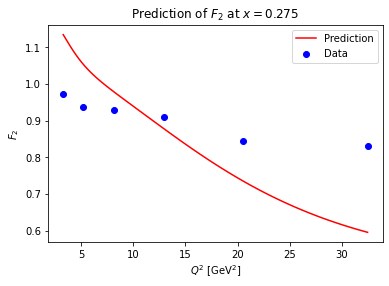

<Figure size 432x288 with 0 Axes>

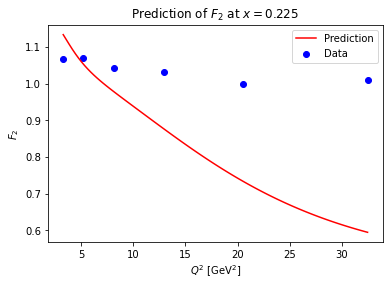

<Figure size 432x288 with 0 Axes>

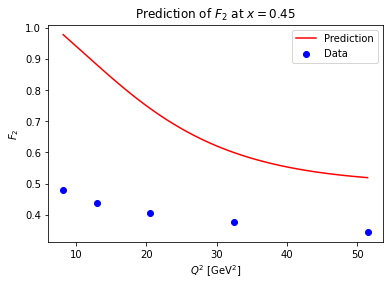

<Figure size 432x288 with 0 Axes>

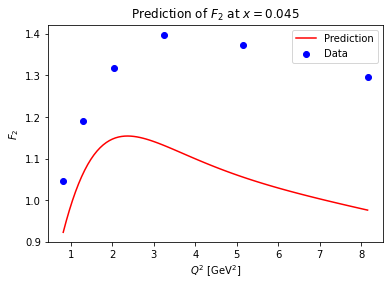

<Figure size 432x288 with 0 Axes>

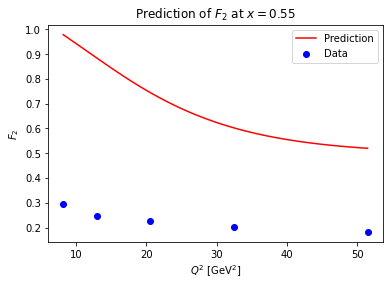

<Figure size 432x288 with 0 Axes>

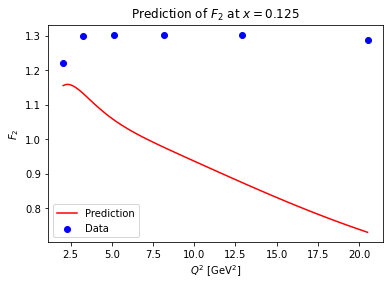

<Figure size 432x288 with 0 Axes>

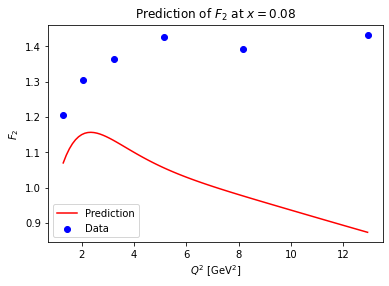

<Figure size 432x288 with 0 Axes>

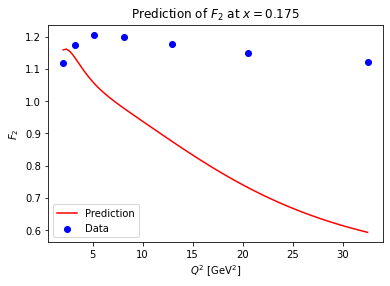

<Figure size 432x288 with 0 Axes>

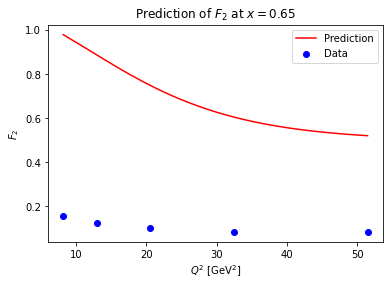

<Figure size 432x288 with 0 Axes>

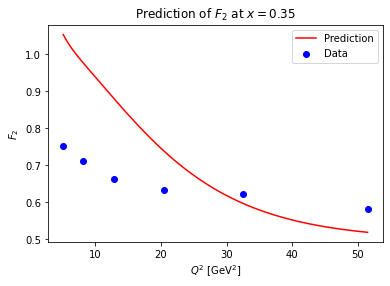

<Figure size 432x288 with 0 Axes>

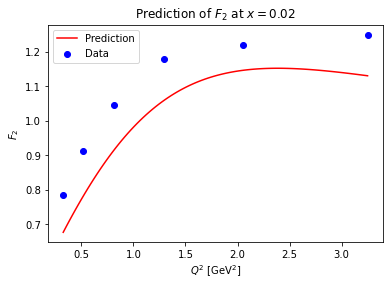

<Figure size 432x288 with 0 Axes>

In [17]:
plot_constant_x(best_model, data_df)

In [18]:
def create_replicas(data_df, runcard):
    n_rep = runcard["nb_replicas"]
    
    y = data_df["y"].to_numpy()
    y_err = data_df["y_err_sys"].to_numpy() + data_df["y_err_stat"].to_numpy()
    y_dist = np.zeros((n_rep, y.shape[0]))
    for i, mean in enumerate(y):
        y_dist[:, i] = np.random.normal(
            loc=mean,
            scale=(y_err[i]),
            size=n_rep,
        ) 
        
    return y_dist

In [23]:
def fit_replicas(data_df, runcard, best_params):
    y_dist = create_replicas(data_df, runcard)
    models = []
    
    for y in y_dist:
        new_data_df = data_df.copy()
        new_data_df["y"] = y
        best_model,_ = model_trainer(data_df, runcard, **best_params)
        models.append(best_model)
    
    return models

In [20]:
def plot_with_reps(models, data_df):
    # loop over x values
    x_set = set(data_df["x_0"])
    for x_value in x_set:
        x_df = data_df[data_df["x_0"]==x_value]
        x = x_df[["x_0", "x_1"]].to_numpy()
        y = x_df["y"].to_numpy()
        y_err = x_df["y_err_stat"].to_numpy() + x_df["y_err_sys"].to_numpy()
        x_grid = np.linspace(x[0], x[-1], 100)
        
        # loop over replicas
        y_pred = []
        for model in models:
            y_pred.append(model.predict(x_grid))
        
        # compute mean and errorbands
        p1_high = np.nanpercentile(y_pred,84,axis=0)
        p1_low = np.nanpercentile(y_pred,16,axis=0)
        p1_mid = (p1_high + p1_low )/2.
        p1_error = (p1_high - p1_low )/2.
        
        p1_mid = p1_mid.reshape(-1)
        p1_error = p1_error.reshape(-1)
        
        # plot
        _, ax = plt.subplots(1, 1) 
        ax.errorbar(x[:, 1], y, yerr=y_err, label = "Data", fmt="ko", capsize=5)
        ax.fill_between(x_grid[:, 1], y1=p1_mid-p1_error, y2=p1_mid+p1_error, color="red", edgecolor="red", label="Prediction", alpha=0.25)
        ax.plot(x_grid[:, 1], p1_mid, color="red", linestyle="dashed")
        ax.legend()
        ax.set_xlabel("$Q^2$ [GeV$^2$]")
        ax.set_ylabel("$F_2$")
        ax.set_title(f"Prediction of $F_2$ at $x={x[0,0]}$")
        plt.show()
        plt.savefig(f"{fits_path}/FIT_{x[0,0]}.png")
        ax.clear()

In [ ]:
models = fit_replicas(data_df, runcard, best_params)

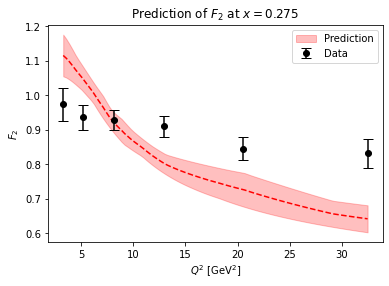

<Figure size 432x288 with 0 Axes>

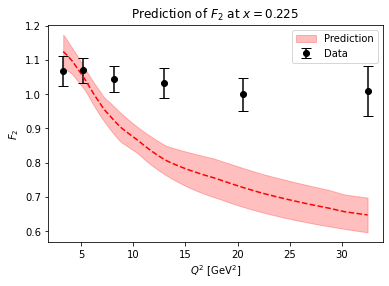

<Figure size 432x288 with 0 Axes>

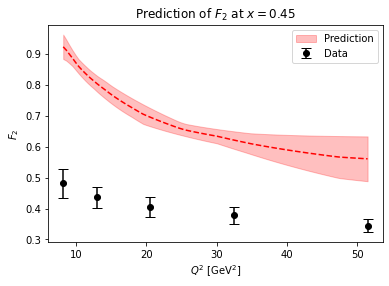

<Figure size 432x288 with 0 Axes>

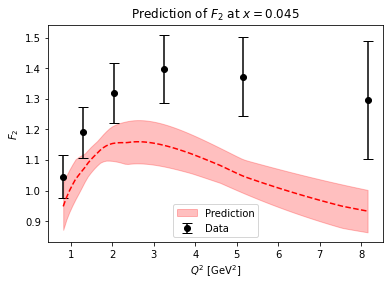

<Figure size 432x288 with 0 Axes>

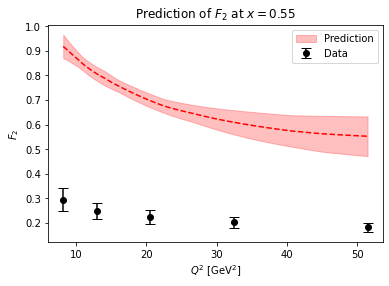

<Figure size 432x288 with 0 Axes>

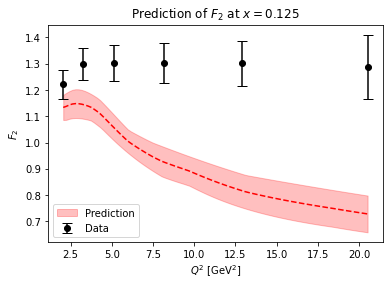

<Figure size 432x288 with 0 Axes>

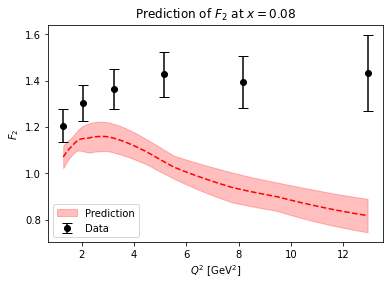

<Figure size 432x288 with 0 Axes>

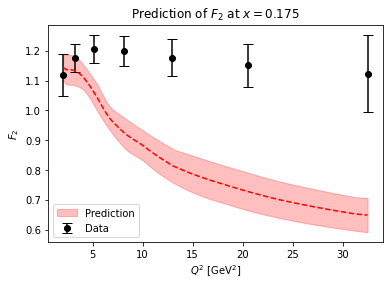

<Figure size 432x288 with 0 Axes>

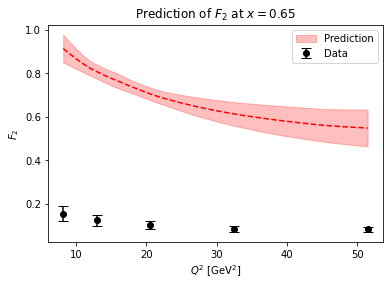

<Figure size 432x288 with 0 Axes>

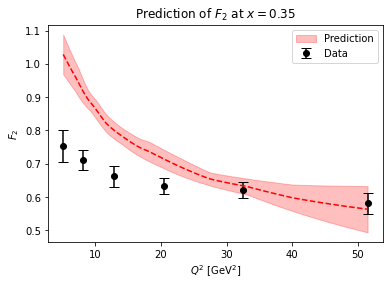

<Figure size 432x288 with 0 Axes>

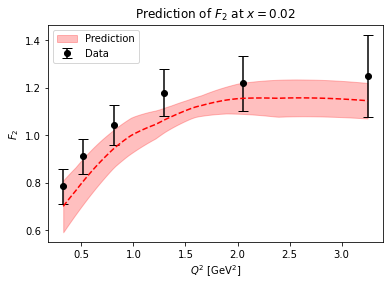

<Figure size 432x288 with 0 Axes>

In [22]:
plot_with_reps(models, data_df)

ToDo:
- !!python/tuple in best_hyperparameters.yaml now deleted by hand